# Домашнє завдання: Прогнозування кредитного ризику

## Мета завдання
Застосувати знання з лекції для побудови моделі логістичної регресії, що прогнозує ймовірність дефолту за кредитом, іншими словами, що людина не поверне кредит. Ви пройдете весь цикл: від дослідницького аналізу до оцінки якості класифікаційної моделі.

## Опис датасету
**Credit Risk Dataset** містить інформацію про 32,000+ позичальників з такими параметрами:
- **person_age**: Вік позичальника
- **person_income**: Річний дохід
- **person_home_ownership**: Тип володіння житлом
- **person_emp_length**: Стаж роботи (в роках)
- **loan_intent**: Мета кредиту
- **loan_grade**: Кредитний рейтинг (A - кращий, F - гірший)
- **loan_amnt**: Сума кредиту
- **loan_int_rate**: Процентна ставка
- **loan_status**: Статус кредиту (0 = сплачено, 1 = дефолт) - **цільова змінна**
- **loan_percent_income**: Відношення кредиту до доходу
- **cb_person_default_on_file**: Історія дефолтів (Y/N)
- **cb_person_cred_hist_length**: Довжина кредитної історії

---

## Завдання 1: Завантаження та перший огляд даних (1 бал)

**Що потрібно зробити:**
1. Завантажте дані з файлу `credit_risk_dataset.csv`
2. Виведіть розмір датасету
3. Покажіть перші 5 рядків
4. Виведіть загальну інформацію про дані (кількість записів, типи колонок)
5. Перевірте розподіл цільової змінної (відсотк даних для кожного класу)

Дайте висновок, це задача збалансованої чи незбалансованої класифікації.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [2]:
# Завантажуємо дані
df = pd.read_csv('/content/credit_risk_dataset.csv')

print(f"Розмір датасету: {df.shape}")
print(f"Кількість позичальників: {df.shape[0]:,}")
print(f"Кількість ознак: {df.shape[1]}")

Розмір датасету: (32581, 12)
Кількість позичальників: 32,581
Кількість ознак: 12


In [3]:
df.head(5)

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
# Загальна інформація
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [5]:
# Розподіл цільової змінної
class_counts = df['loan_status'].value_counts()
class_perc = df['loan_status'].value_counts(normalize=True) * 100

class_perc

,proportion
loan_status,
0,78.183604
1,21.816396



**Висновок:** Датасет незбалансований (78% vs 22%).


---

## Завдання 2: Дослідницький аналіз даних (EDA) (4 бали)

**Що потрібно зробити:**
1. Обчисліть відсоток пропущених значень в колонках. За наявності пропущених значень - заповніть їх медіаною для числових колонок і найбільш частим значеннмя для категоріальних.
2. Проаналізуйте розподіл числових змінних.
3. Знайдіть та обробіть викиди в колонці person_income з допомогою [Interquartile range](https://uk.wikipedia.org/wiki/%D0%9C%D1%96%D0%B6%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D0%BB%D1%8C%D0%BD%D0%B8%D0%B9_%D1%80%D0%BE%D0%B7%D0%BC%D0%B0%D1%85).
4. Проаналізуйте категоріальні змінні відносно цільової та частоту зустрічання різних значень в них.
5. Візуалізуйте взаємозв'язок ознак з цільовою змінною.


In [6]:
# Пропущені значення: кількість і їх відсоток в кожній з колонок
missing_data = df.isnull().sum()
missing_percent = (missing_data / len(df)) * 100

missing_table = pd.DataFrame({
    'Кількість': missing_data,
    'Відсоток': missing_percent
    })

missing_table.round(3)


,Кількість,Відсоток
person_age,0,0.000
person_income,0,0.000
person_home_ownership,0,0.000
person_emp_length,895,2.747
loan_intent,0,0.000
loan_grade,0,0.000
loan_amnt,0,0.000
loan_int_rate,3116,9.564
loan_status,0,0.000
loan_percent_income,0,0.000


In [7]:
# Заповнюємо пропуски медіаною
df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
df['loan_int_rate'].fillna(df['loan_int_rate'].median(), inplace=True)

/tmp/ipython-input-4261149712.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['person_emp_length'].fillna(df['person_emp_length'].median(), inplace=True)
/tmp/ipython-input-4261149712.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method

In [8]:
# Базова статистика для числових змінних
stats = df.describe()
stats

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.767994,9589.371106,11.009620,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.087372,6322.086646,3.081611,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,8.490000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.110000,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


In [9]:
# Розподіл числових змінних

num_cols = [
    "person_age", "person_income", "person_emp_length",
    "loan_amnt", "loan_int_rate", "loan_percent_income",
    "cb_person_cred_hist_length"
]

for col in num_cols:
    fig = px.histogram(
        df,
        x=col,
        color="loan_status",   # розподіл окремо для сплачених / дефолтів
        nbins=40,
        opacity=0.6,
        barmode="overlay",
        title=f"Розподіл {col} за статусом кредиту"
    )
    fig.show()

In [10]:
# Робота з викидами за правилом IQR

# 1. Розрахунок меж IQR
Q1 = df['person_income'].quantile(0.25)
Q3 = df['person_income'].quantile(0.75)
IQR = Q3 - Q1

low = Q1 - 1.5 * IQR
high = Q3 + 1.5 * IQR

print(f"Межі для доходів за IQR: від {low:.0f} до {high:.0f}")

# 2. Фільтрація (видалення викидів)
df_no_outliers = df[(df['person_income'] >= low) & (df['person_income'] <= high)]

print(f"\nБуло рядків: {len(df)}")
print(f"Залишилось після очищення: {len(df_no_outliers)}")
print(f"Видалено викидів: {len(df) - len(df_no_outliers)}")

# 3. Візуалізація
fig2 = px.histogram(df_no_outliers, x="person_income", nbins=50,
                    title="Розподіл доходів (після очищення IQR)")
fig2.show()


Межі для доходів за IQR: від -22550 до 140250

Було рядків: 32581
Залишилось після очищення: 31097
Видалено викидів: 1484


In [11]:
# Аналіз категоріальних змінних відносно loan_status
# Список категоріальних змінних
cat_cols = ["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]
target_col = "loan_status"

for c in cat_cols:
    print(f"\nКатегоріальна змінна: {c}")
    freq = df_no_outliers[c].value_counts(dropna=False)
    print("Частота значень:")
    print(freq)

    # частка дефолтів
    default_rate = df_no_outliers.groupby(c)[target_col].mean().reset_index()
    default_rate[target_col] = default_rate[target_col] * 100

    # інтерактивний bar chart
    fig = px.bar(default_rate,
                 x=c,
                 y=target_col,
                 text=default_rate[target_col].round(2),
                 title=f"Частка дефолтів (%) за {c}",
                 labels={c: c, target_col: "% дефолтів"})
    fig.update_traces(textposition="outside")
    fig.show()


Категоріальна змінна: person_home_ownership
Частота значень:
person_home_ownership
RENT        16102
MORTGAGE    12426
OWN          2469
OTHER         100
Name: count, dtype: int64



Категоріальна змінна: loan_intent
Частота значень:
loan_intent
EDUCATION            6201
MEDICAL              5846
VENTURE              5445
PERSONAL             5260
DEBTCONSOLIDATION    4955
HOMEIMPROVEMENT      3390
Name: count, dtype: int64



Категоріальна змінна: loan_grade
Частота значень:
loan_grade
A    10343
B     9924
C     6191
D     3459
E      899
F      221
G       60
Name: count, dtype: int64



Категоріальна змінна: cb_person_default_on_file
Частота значень:
cb_person_default_on_file
N    25626
Y     5471
Name: count, dtype: int64



---

## Завдання 3: Аналіз кореляцій та Feature Engineering (3 бали)

**Що потрібно зробити:**
1. Побудуйте матрицю кореляцій для числових змінних.
2. Закодуйте категоріальні змінні.
3. Виберіть фінальний набір ознак, можна лишити всі, якщо ви вважаєте, що це - доцільно.



In [12]:
# Матриця кореляцій
correlation_matrix = df_no_outliers.select_dtypes('number').corr()

# Візуалізація кореляцій
fig = px.imshow(
    correlation_matrix,
    text_auto='.2f',
    color_continuous_scale='RdBu_r',
    title='Матриця кореляцій всіх числових ознак',
    labels=dict(color="Кореляція")
)

fig.show()



In [13]:
# Бінарне кодування для Y/N
df_no_outliers['cb_person_default_on_file_bc'] = df_no_outliers['cb_person_default_on_file'].map({'Y': 1, 'N': 0})

# One-Hot Encoding для категоріальних змінних
cols_for_ohe = ['cb_person_default_on_file', 'person_home_ownership', 'loan_intent', 'loan_grade']

df_encoded = pd.get_dummies(df_no_outliers, columns=cols_for_ohe, drop_first=True)
df_encoded

/tmp/ipython-input-2574006083.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length,cb_person_default_on_file_bc,cb_person_default_on_file_Y,...,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G
0,22,59000,123.0,35000,16.02,1,0.59,3,1,True,...,False,False,True,False,False,False,True,False,False,False
1,21,9600,5.0,1000,11.14,0,0.10,2,0,False,...,False,False,False,False,True,False,False,False,False,False
2,25,9600,1.0,5500,12.87,1,0.57,3,0,False,...,False,True,False,False,False,True,False,False,False,False
3,23,65500,4.0,35000,15.23,1,0.53,2,0,False,...,False,True,False,False,False,True,False,False,False,False
4,24,54400,8.0,35000,14.27,1,0.55,4,1,True,...,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32575,52,64500,0.0,5000,11.26,0,0.08,20,0,False,...,False,False,False,False,True,False,False,False,False,False
32576,57,53000,1.0,5800,13.16,0,0.11,30,0,False,...,False,False,True,False,False,True,False,False,False,False
32577,54,120000,4.0,17625,7.49,0,0.15,19,0,False,...,False,False,True,False,False,False,False,False,False,False
32578,65,76000,3.0,35000,10.99,1,0.46,28,0,False,...,True,False,False,False,True,False,False,False,False,False


In [14]:
# Фінальний набір
df_model= df_encoded.copy()

print("✅ Фінальний набір даних сформовано")
print(f"Розмір датасету: {df_model.shape}")
print(f"Кількість ознак (без цільової): {df_model.shape[1]-1}")

print("\n📌 Список фінальних колонок:")
display(df_model.columns.tolist())



✅ Фінальний набір даних сформовано
Розмір датасету: (31097, 24)
Кількість ознак (без цільової): 23

📌 Список фінальних колонок:


['person_age',
 'person_income',
 'person_emp_length',
 'loan_amnt',
 'loan_int_rate',
 'loan_status',
 'loan_percent_income',
 'cb_person_cred_hist_length',
 'cb_person_default_on_file_bc',
 'cb_person_default_on_file_Y',
 'person_home_ownership_OTHER',
 'person_home_ownership_OWN',
 'person_home_ownership_RENT',
 'loan_intent_EDUCATION',
 'loan_intent_HOMEIMPROVEMENT',
 'loan_intent_MEDICAL',
 'loan_intent_PERSONAL',
 'loan_intent_VENTURE',
 'loan_grade_B',
 'loan_grade_C',
 'loan_grade_D',
 'loan_grade_E',
 'loan_grade_F',
 'loan_grade_G']


---

## Завдання 4: Підготовка даних та навчання моделі (3 бали)

**Що потрібно зробити:**
1. Розділіть дані на X та y
2. Поділіть на навчальну та тестову вибірки
3. Застосуйте масштабування
4. Навчіть модель логістичної регресії
5. Зробіть прогнози на тренувальній та тестовій вибірках.



In [15]:
from sklearn.model_selection import train_test_split

# Розділення на X та y
X = df_model.drop('loan_status', axis=1)
y = df_model['loan_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTrain: {X_train.shape}")
print(f"Test: {X_test.shape}")
print(f"\nДефолти в train: {y_train.mean():.1%}")
print(f"Дефолти в test: {y_test.mean():.1%}")


Train: (24877, 23)
Test: (6220, 23)

Дефолти в train: 22.4%
Дефолти в test: 22.4%


In [16]:
from sklearn.preprocessing import StandardScaler

# Масштабування даних
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
from sklearn.linear_model import LogisticRegression

# Створюємо та навчаємо модель
model = LogisticRegression(random_state=42, max_iter=1000)
model.fit(X_train_scaled, y_train)

print("Модель навчена!")

Модель навчена!


In [22]:
# Прогнозуємо
y_train_pred = model.predict(X_train_scaled)
y_train_pred_proba = model.predict_proba(X_train_scaled)

y_test_pred = model.predict(X_test_scaled)
y_test_pred_proba = model.predict_proba(X_test_scaled)

In [24]:
# Приклад прогнозів для перших 5 клієнтів
sample_predictions = pd.DataFrame({
    'Реальний статус': y_test.values[:5],
    'Прогноз': y_test_pred[:5],
    'Ймовірність сплати кредиту': y_test_pred_proba[:5, 0].round(3),
    'Ймовірність дефолту': y_test_pred_proba[:5, 1].round(3)
})

print(sample_predictions)


   Реальний статус  Прогноз  Ймовірність сплати кредиту  Ймовірність дефолту
0                0        0                       0.969                0.031
1                0        0                       0.986                0.014
2                0        0                       0.965                0.035
3                0        0                       0.965                0.035
4                0        1                       0.166                0.834



---

## Завдання 5: Оцінка якості моделі (4 бали)

**Що потрібно зробити:**
1. Побудуйте confusion matrix.
2. Обчисліть основні метрики (accuracy, precision, recall, f1).
3. Побудуйте ROC-криву та обчисліть AUC
4. Проаналізуйте важливість ознак.
5. Зробіть висновки про якість моделі та які ознаки найбільше впливають на прогноз.


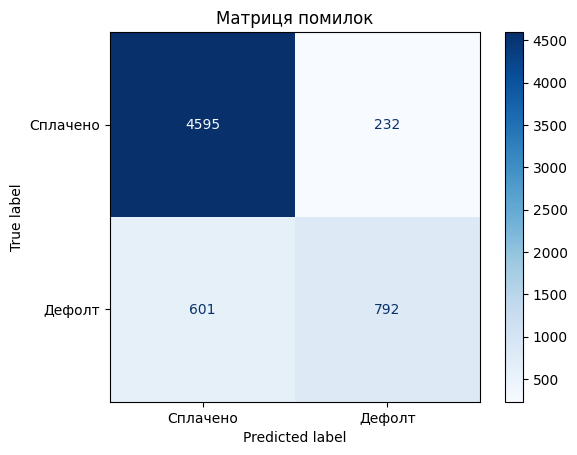

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Сплачено', 'Дефолт'])
disp.plot(cmap='Blues')
plt.title('Матриця помилок')
plt.show()

In [28]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Основні метрикиметрики (accuracy, precision, recall, f1)
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)

print("МЕТРИКИ ЯКОСТІ МОДЕЛІ:")
print(f"\nAccuracy (Точність):    {accuracy:.3f}")
print(f"Precision (Влучність):  {precision:.3f}")
print(f"Recall (Повнота):       {recall:.3f}")
print(f"F1-score:               {f1:.3f}")

МЕТРИКИ ЯКОСТІ МОДЕЛІ:

Accuracy (Точність):    0.866
Precision (Влучність):  0.773
Recall (Повнота):       0.569
F1-score:               0.655


In [30]:
from sklearn.metrics import roc_curve, roc_auc_score

# Обчислюємо ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba[:, 1])
auc = roc_auc_score(y_test, y_test_pred_proba[:, 1])

# Візуалізація
fig = go.Figure()
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC (AUC = {auc:.3f})'))
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash'),
                        name='Випадковий класифікатор'))
fig.update_layout(
    title='ROC-крива',
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    height=500
)
fig.show()

In [31]:
# Важливість ознак
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'coefficient': model.coef_[0],
    'abs_coefficient': np.abs(model.coef_[0])
}).sort_values('abs_coefficient', ascending=False)

feature_importance

,feature,coefficient,abs_coefficient
5,loan_percent_income,1.315648,1.315648
19,loan_grade_D,0.817970,0.817970
3,loan_amnt,-0.543021,0.543021
20,loan_grade_E,0.480475,0.480475
10,person_home_ownership_OWN,-0.459802,0.459802
11,person_home_ownership_RENT,0.403687,0.403687
16,loan_intent_VENTURE,-0.400314,0.400314
12,loan_intent_EDUCATION,-0.326937,0.326937
22,loan_grade_G,0.312187,0.312187
21,loan_grade_F,0.271018,0.271018


## Висновки по моделі логістичної регресії

### Якість моделі
Модель добре прогнозує клас "сплачено", але має середню чутливість до класу "дефолт". Це означає, що частина проблемних позичальників може залишатися непоміченою.

### Найважливіші ознаки
1. **loan_percent_income (+1.316)** — більша частка кредиту від доходу = вищий ризик дефолту.  
2. **loan_grade (D, E, F, G)** — гірший кредитний рейтинг суттєво підвищує ймовірність дефолту.  
3. **loan_amnt (−0.543)** — великі кредити частіше беруть фінансово стабільні клієнти.  
4. **person_home_ownership (OWN −0.460, RENT +0.404)** — власники житла надійніші за орендарів.  
5. **loan_intent (VENTURE, EDUCATION, PERSONAL)** — кредити на бізнес, освіту та особисті потреби більш ризикові.  
6. **person_income (−0.178)** — вищий дохід зменшує ймовірність дефолту.  
7. **loan_int_rate (+0.157)** — вища ставка = більший ризик неповернення.  

### Загальний висновок
Модель виявила ключові фактори ризику:  
- співвідношення кредит/дохід,  
- кредитний рейтинг,  
- житловий статус,  
- мета кредиту.  

Для бізнесу варто розглянути оптимізацію порогу класифікації або використання більш складних моделей, щоб краще виявляти потенційних дефолтерів.


---

## Завдання 6: Оптимізація порогу та бізнес-аналіз (2 бали)

**Що потрібно зробити:**
1. Проаналізуйте метрики precision, recall, F1 при різних порогах класифікації (мінімум - 5 різних порогів). Візуалізуйте як змінюються метрики якості при зміні порогу.
2. Оберіть оптимальний поріг для бізнес-задачі - можна обрати виходячи з попереднього пункту, або додати своїх роздумів і обрати інший.



In [34]:
# Аналіз різних порогів
thresholds = np.arange(0.1, 0.9, 0.05)
metrics_by_threshold = []

for threshold in thresholds:
    y_pred_custom = (y_test_pred_proba[:, 1] >= threshold).astype(int)

    metrics_by_threshold.append({
        'threshold': threshold,
        'precision': precision_score(y_test, y_pred_custom),
        'recall': recall_score(y_test, y_pred_custom),
        'f1': f1_score(y_test, y_pred_custom)
    })

metrics_df = pd.DataFrame(metrics_by_threshold)

# Візуалізація
fig = px.line(
    metrics_df.melt(id_vars='threshold'),
    x='threshold',
    y='value',
    color='variable',
    title='Метрики при різних порогах рішення',
    labels={'value': 'Значення метрики', 'threshold': 'Поріг'},
)
fig.show()

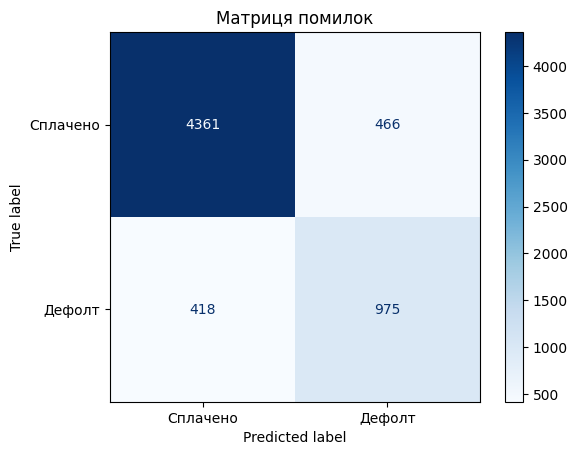

In [35]:
y_pred_opt = y_test_pred_proba[:,1]>=0.35

cm = confusion_matrix(y_test, y_pred_opt)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Сплачено', 'Дефолт'])
disp.plot(cmap='Blues')
plt.title('Матриця помилок')
plt.show()


---

## Завдання 7 (Опціональне): Покращення моделі та висновки (2 бали)

**Що потрібно зробити:**

На цих же даних навчіть DecisionTreeClassifier та RandomForestClassifier. Яка з трьох моделей дає найкращий результат на тестовому наборі?

Поріг класифікації можна для порівняння якостей моделей використовувати стандартний 0.5, або той, що ви виявили, як оптимальний на попередньому кроці.


In [36]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Навчаємо альтернативні моделі
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_pred_proba)
    })

results_df = pd.DataFrame(results).round(3)
display(results_df)

,Model,Accuracy,Precision,Recall,F1,AUC
0,Logistic Regression,0.866,0.773,0.569,0.655,0.874
1,Decision Tree,0.903,0.954,0.594,0.732,0.872
2,Random Forest,0.928,0.952,0.715,0.817,0.926




**Посилання на Google Colab, оскільки завдання виконувала з використанням Plotly для побудови графіків:** https://colab.research.google.com/drive/1gbDUZAEf-zmZIk86NOO5-DZP6sdL56rZ#scrollTo=n4sl7HbS53uG
